## Отчет об экспериментах по подсчету и улучшению когерентности

Коллекция: ММРО-ИОИ, документов: 1061, слов в словаре: 7805 (tex->текст, лемматизация и выкидывание стоп-слов по версии Саши Плавина, дополнительно отбросила редкие слова, встречающиеся менее 4 раз по всей коллекции). 

Число тем: 50 предметных + 10 фоновых. Для каждой модели считаю набор привычных метрик и рисую на 3 графиках.

Код ниже оставляю в отчете, чтобы я потом могла в точности восстановить все параметры экспериментов.

In [6]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import artm

batch_vectorizer = artm.BatchVectorizer(data_path='datasets/mmro', data_format='batches')

background_topics = []
domain_topics = []
all_topics = []

for i in range(0, 60):
    topic_name = "topic" + str(i)
    all_topics.append(topic_name)
    if i < 50:
        domain_topics.append(topic_name)
    else:
        background_topics.append(topic_name)
        
def prepare(model):
    model.load_dictionary(dictionary_name='dictionary', dictionary_path='datasets/mmro/dictionary')
    model.initialize(dictionary_name='dictionary')
 
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                      use_unigram_document_model=False, # где-то сохраняется, сколько раз pwd = 0?
                                      dictionary_name='dictionary'))

    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', 
                                           topic_names = domain_topics))

    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', 
                                            topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop10TokensScore', 
                                         num_tokens=10, 
                                         dictionary_name = 'cooc_dictionary',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop100TokensScore', 
                                         num_tokens=100, 
                                         dictionary_name = 'cooc_dictionary',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='BackgroundTopTokensScore', 
                                         num_tokens=10, 
                                         topic_names = background_topics))

    model.scores.add(artm.TopicKernelScore(name='DomainTopicKernelScore', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'cooc_dictionary',
                                           topic_names = domain_topics))

    model.scores.add(artm.TopicKernelScore(name='BackgroundTopicKernelScore', 
                                           probability_mass_threshold=0.25, 
                                           topic_names = background_topics))
    
    model.scores.add(artm.TopicMassPhiScore(name='BackgroundMassScore',  
                                           topic_names = background_topics))

def figures(model):
    # perplexity
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots()
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Perplexity', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi sparsity")
    ax2.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta sparsity")
    #ax2.plot(x, model.score_tracker['BackgroundMassScore'].value[1:], 'r^', linewidth=2, label="Background ratio")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()
    
    # kernels
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots()
    ax1.plot(x, model.score_tracker['DomainTopicKernelScore'].average_size[1:], 'g-', linewidth=2, label="size")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Size', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['DomainTopicKernelScore'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax2.plot(x, model.score_tracker['DomainTopicKernelScore'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()
    
    # coherence
    x = range(model.num_phi_updates)[1:]
    plt.plot(x, model.score_tracker['DomainTop10TokensScore'].average_coherence[1:], 'b--', label="top10", linewidth=2)
    plt.plot(x, model.score_tracker['DomainTop100TokensScore'].average_coherence[1:], 'r--', label="top100", linewidth=2)
    plt.plot(x, model.score_tracker['DomainTopicKernelScore'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Average coherence')
    plt.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()       

### 1. Подсчет когерентности различными способами для оффлайновой PLSA модели

Формула когерентности имеет несколько разновидностей:
- <b>positive PMI</b>. Близко к [Newman], он не уточняет что делать с отрицательными и минус бесконечными значениями.

$$pPMI = \left[ \log \frac{n(u,v)\, n}{n(u)\, n(v)}\right]_{+}$$ 

- <b>логарифм условной вероятности</b>, вероятность сглаживают [Mimno].

$$ score = \log \frac{n(u,v) + 1}{n(v)} $$

- <b> td-idf coherence</b> [Кольцов].

Любой такой скор можно усреднить по всем парам в топ-k слов, а затем усреднить по всем темам.

Кроме формулы разнятся способы подсчета счетчиков для слов и для пар слов:
- число документов, в которых встретилась пара слов (слово) [Mimno, Кольцов]
- число окон заданной ширины, в которых встретилась пара слов (слово) [Newman].

Кроме того, [Newman] советует использовать внешнюю коллекцию для подсчетов счетчиков, но мы пока этого не делаем,  как и [Mimno, Кольцов].

### positive PMI + окно ширины 10:

- Когерентность топ-10 лучше топ-100, топ-100 лучше ядра.

- Все меры в норме, отличия от привычного:
    - сильная разреженность матрицы Фи
    - пик когерентности ядра в тот момент, пока оно еще маленькое

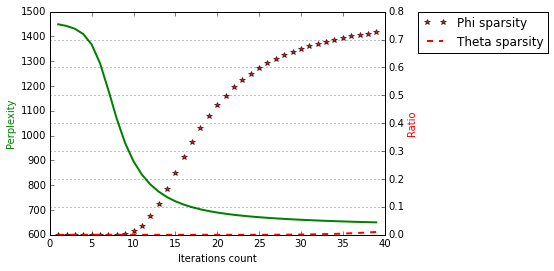

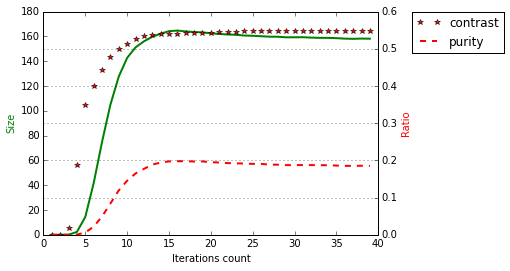

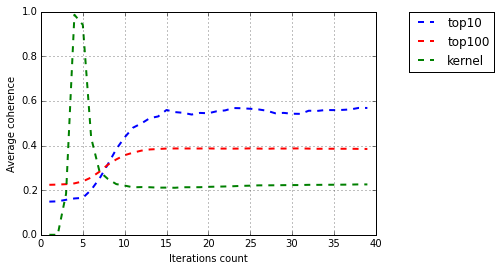

In [7]:
# PLSA
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_w10_dictionary')
prepare(model)
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)
figures(model)


### positive PMI + окно ширины 100:

- Все когерентности становятся примерно одинаковыми, около 0.6.


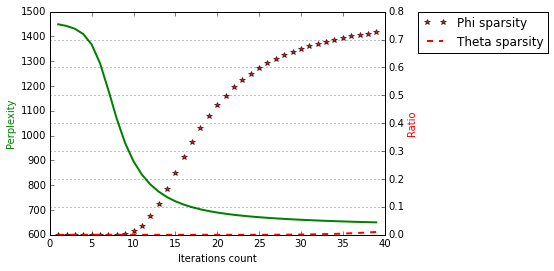

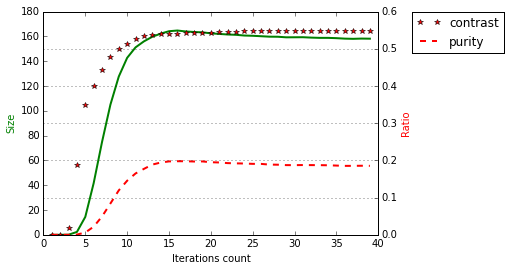

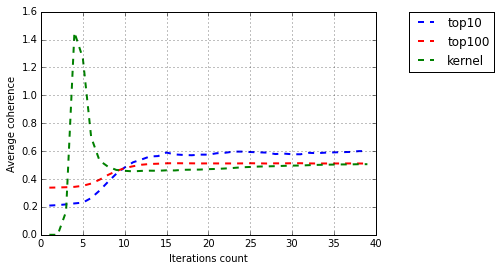

In [7]:
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_w100_dictionary')
prepare(model)
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)
figures(model)

### positive PMI + частоты по документу:

- Когерентность ядра существенно лучше когерентности топов.
- Именно такой вариант когерентностия обычно считала у себя, если не смотреть на странный пик когерентности ядра, то остальное похоже: топы приходят к 0.2, ядро к 0.8.

Можно сделать такой вывод: ядра содержат достаточно редкие тематичные термины, которые со-встречаются в одних документах, но не встречаются рядом в предложениях. Это вполне согласуется с тем, что мы уже выясняли: слова ядер разбросаны по документу среди большого числа общей лексики (он не соседи и не хотели помогать друг другу определять профили ptdw). 

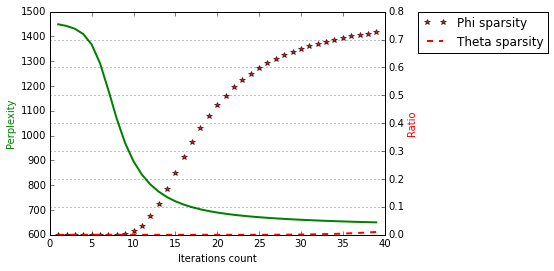

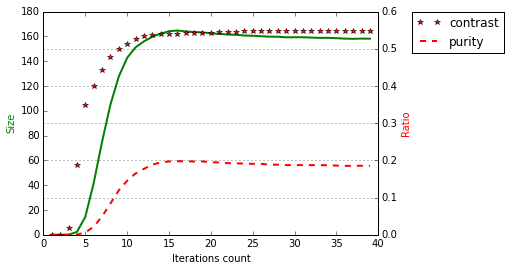

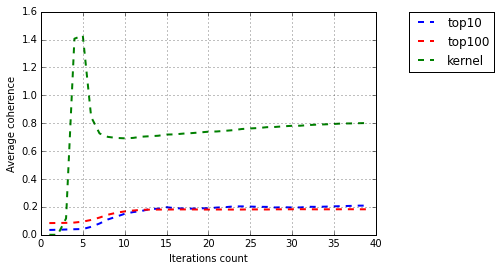

In [9]:
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_doc_dictionary')
prepare(model)
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)
figures(model)

### [Mimno]: логарифм условной вероятности + частоты по документу.
- Когерентности отрицательные, это логично.
- Когерентности убывают! Это очень странно, в статье есть пример роста когерентности для модели LDA. С другой стороны, я, может быть, даже могу поверить в их убывание: условные вероятности очень несимметричны. p(алгоритм|голосование) близко к 0, p(голосование|алгоритм), допустим, -3. Большинство значений на рандомных парах слов где-то между, ближе к 0. В статье и у меня используются p(слова пониже в топе | слова повыше), т.е. при перемешивании топа скор можно безумно сильно измениться. Если не угадать с порядком может быть выгоднее набрать просто рандомных слов, не претендующих на корреляцию :) В любом случае, багу ищу но пока не вижу.

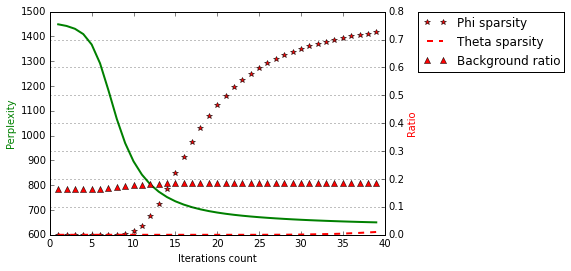

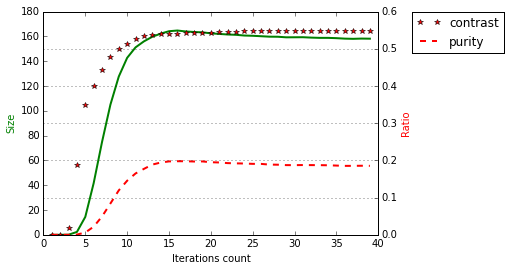

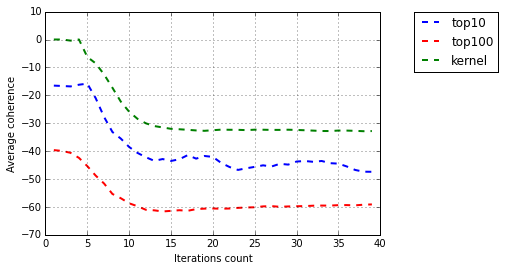

In [15]:
# Mimno убывают в PLSA
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/mimno_dictionary')
prepare(model)
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)
figures(model)

### 2. Настраиваем модель раз-сгла-дек и пробуем добиться привычных результатов.

- Декоррелируем сильно и сразу, сглаживаем сразу, разреживаем после 10 итерации (тету с константным коэффициентом, фи с сильно растущим в течение 10 итераций. Когерентность считаем по pPMI + по документам.
- Получается неплохо:
    - Полколлекции сразу за счет декоррелятора улетает в фон. 
    - Разреживание фона не добавляет, удается добиться ~0.9, продолжая описывать все те же слова.
    - Немного улучшаются чистота и контраст.
    - Сильно улучшаются когерентности топов, топ-10 даже обгоняет ядро, которое, кстати, не меняет свою когерентность. Ровно так же было и у меня, проверила.

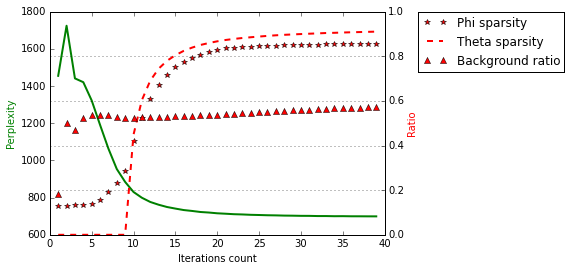

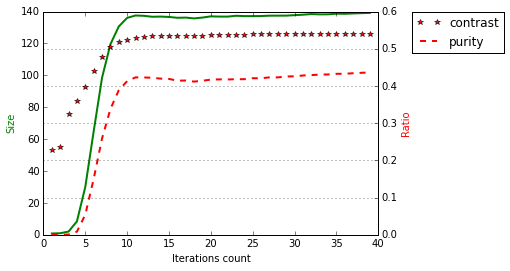

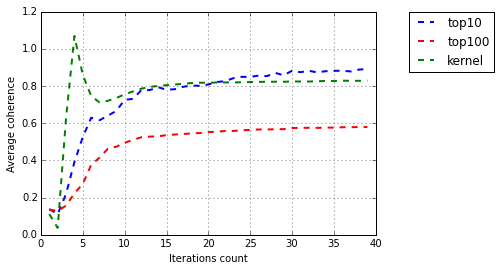

In [6]:
# Добрая модель с сильным декоррелятором, pPMI_doc
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_doc_dictionary')
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e-6, topic_names=domain_topics))
for i in range(10):
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    model.regularizers['SparsePhi'].tau *= 3
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
figures(model)

### Все то же самое, но:
- Усиливаем разреживание
- Существенно улучшаются чистота и контраст, когерентностям все равно, пепрелексия вздрагивает.

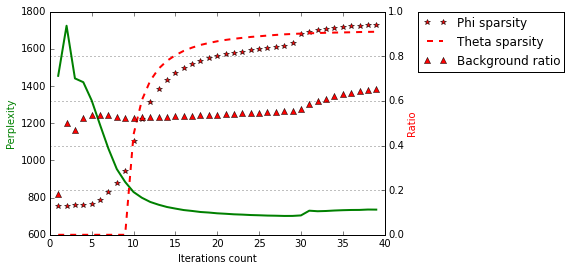

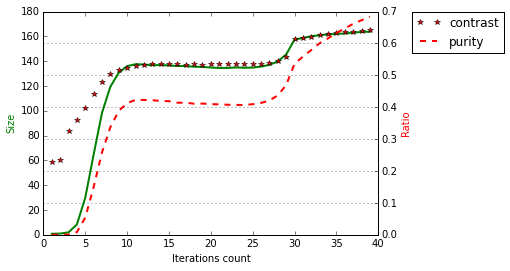

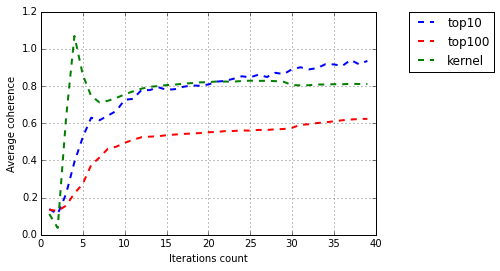

In [7]:
# Злая модель с сильным декоррелятором
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_doc_dictionary')
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e-6, topic_names=domain_topics))
for i in range(20):
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    model.regularizers['SparsePhi'].tau *= 2
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
figures(model)

### Топ-слова предметных и фоновых тем для этой модели:
- кажется, что предметные темы чересчур из редких слов, я их на этой коллекции вижу впервые :)
- фон как всегда

In [12]:
for topic_name in domain_topics:
    print topic_name + ': ',
    tokens = model.score_tracker['DomainTop10TokensScore'].last_topic_info[topic_name].tokens
    for token in tokens:
        print token,
    print

topic0:  контур эталон грань индикатор интегральный кватернион контурный точечный векторный кватернионный
topic1:  кластер кластеризация тренд кластерный внимание средний наличие сезонность трудоустройство категория
topic2:  конфигурация разметка метка словарь минимум инициализация разметить ограничение энергия положительный
topic3:  оператор подсистема понятие контекст трикластер формальный трикластеризация радиостанция рекомендательный тег
topic4:  вейвлёт период возмущение геомагнитный особенность составлять аномальный магнитный месяц поль
topic5:  представление энтропия примитив уровень мера циклический боков кодовый ансамбль лепестковый
topic6:  дескриптор размерность снижение молекула молекулярный соединение химический свойство нечёткий многообразие
topic7:  сходство компактность столп нормировка конкурентный место коллективный петереть ансамблевый переход
topic8:  закономерность эксперт переменный экспертный логический показатель временной ряд предиктор разбиение
topic9:  скелет

In [13]:
for topic_name in background_topics:
    print topic_name + ': ',
    tokens = model.score_tracker['BackgroundTopTokensScore'].last_topic_info[topic_name].tokens
    for token in tokens:
        print token,
    print

topic50:  быть который множество модель такой являться точка мочь один каждый
topic51:  система дать анализ метод решение задача время результат работа исследование
topic52:  функция значение число быть мера качество случай каждый точка задача
topic53:  изображение точка область объект обработка преобразование метод являться который распознавание
topic54:  алгоритм множество построение набор число задача работа который являться элемент
topic55:  выборка класс объект обучение обучать классификация правило параметр распознавание каждый
topic56:  оценка метод быть значение получить величина который можно распределение функция
topic57:  модель метод матрица коэффициент параметр вектор задача дать значение работа
topic58:  задача последовательность решение вектор множество алгоритм число подмножество набор анализ
topic59:  объект признак распознавание задача расстояние образ множество матрица пространство который


### Другие подсчеты когерентности для предыдущего раз-сгла-дек-а:
- <b>Mimno</b> все еще убывают, и здесь они еще меньше, чем в PLSA
- <b>pPMI + окно в 100 слов</b> ведут себя хорошо: когерентность топ-10 повышается с 0.6 до 1.4, топ-100 с 0.6 до 0.8

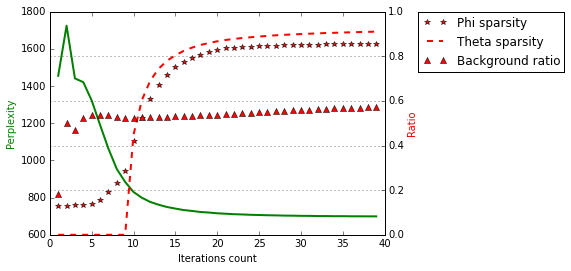

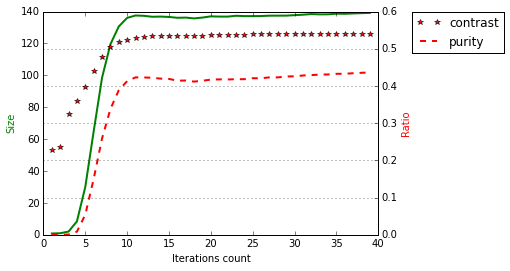

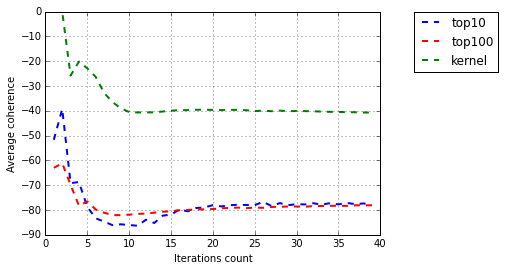

In [16]:
# Mimno убывают и не улучшаются в ARTM
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/mimno_dictionary')
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e-6, topic_names=domain_topics))
for i in range(10):
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    model.regularizers['SparsePhi'].tau *= 3
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
figures(model)

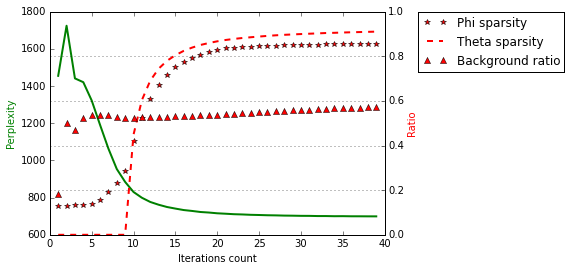

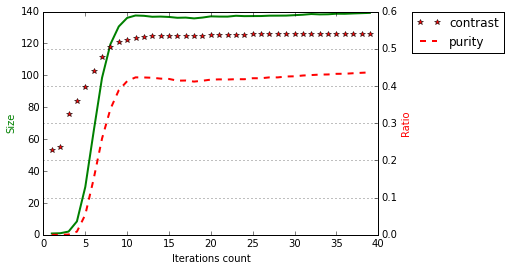

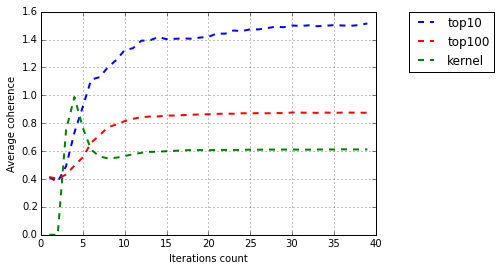

In [22]:
# Добрая модель с сильным декоррелятором, pPMI_w100
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_w100_dictionary')
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e-6, topic_names=domain_topics))
for i in range(10):
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    model.regularizers['SparsePhi'].tau *= 3
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
figures(model)

### 3. Регуляризатор улучшения когерентности M-шага
- Наконец-то мы до него добрались! Но он совершенно не хочет работать :(

Ниже я добавляю в раз-сгла-дек модель улучшение когерентности с 10-ой итерации, одновременно с разреживанием. Вообще, он очень сильно сглаживает матрицу Фи, поэтому кажется, что одновременно противодействовать ему разреживанием - это правильно.

У регуляризатора есть свобода - какие оценки совместной встречаемости брать. Здесь это pPMI + окно в 100 слов.

Когерентность далее везде подсчитывается по pPMI + окно в 100 слов.

Результат - перплексия рушится, когерентность не меняется. Коэффициент регуляризации меняла по-всякому.

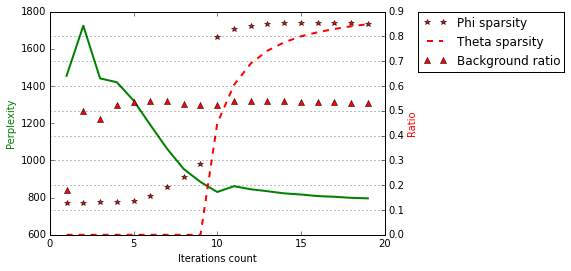

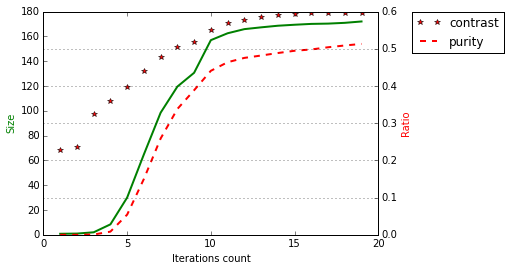

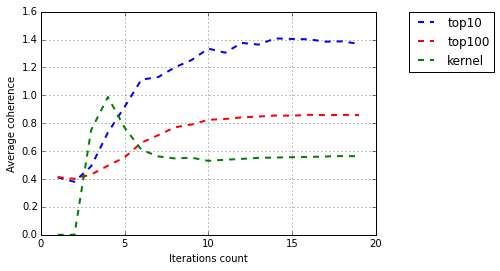

In [25]:
# Пример того, как не получается с pPMI_w100 в ImproveCoherence
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_w100_dictionary')
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
model.regularizers.add(artm.ImproveCoherencePhiRegularizer(name='Coherence', tau=0.0001, dictionary_name='cooc_dictionary'))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
figures(model)

### Условные вероятности для регуляризатора когерентности
Здесь мы с надеждой вспоминаем, что согласно теории оценки совместной встречаемости должны быть условные вероятности p(слова, которому правим $n_{wt}$ | когерентное слово). Считаю их на основе со-встречаемостях в окнах ширины 100. 

При маленьком коэффициенте не происходит ничего не плохого, ни хорошего:

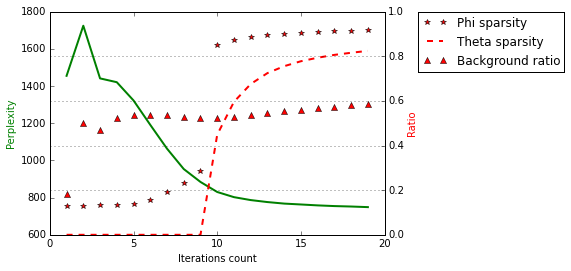

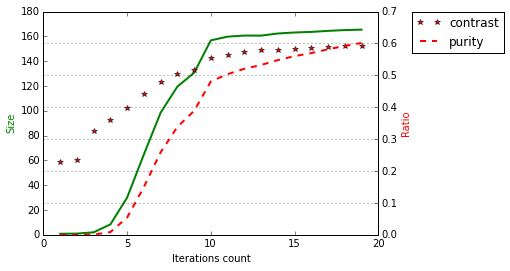

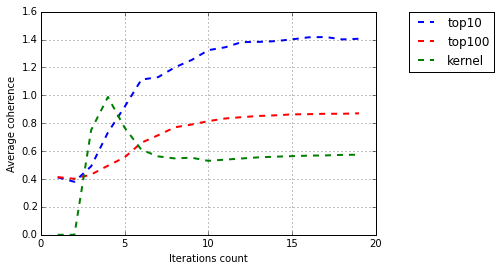

In [34]:
# Пробуем с condprob_w100 в ImproveCoherence
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_w100_dictionary')
model.load_dictionary(dictionary_name='reg_dictionary', dictionary_path='datasets/mmro/condprob_w100_dictionary')
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
model.regularizers.add(artm.ImproveCoherencePhiRegularizer(name='Coherence', tau=0.0001, dictionary_name='reg_dictionary'))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
figures(model)

#### При постепенном увеличении коэффициента в какой-то момент плохеет и перплексии, и когерентностям:

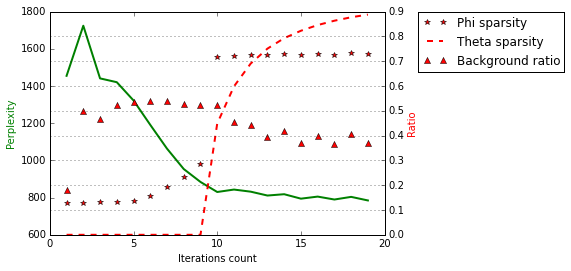

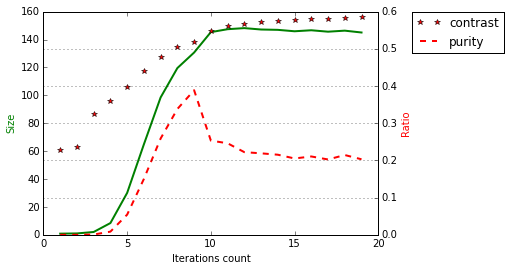

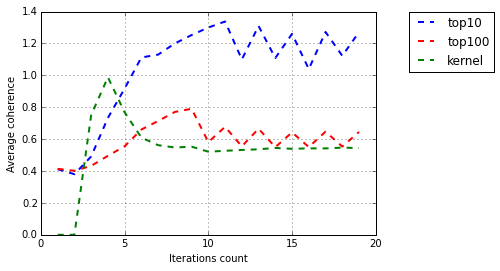

In [3]:
# Пробуем с condprob_w100 в ImproveCoherence
model = artm.ARTM(topic_names = all_topics)
model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='datasets/mmro/pPMI_w100_dictionary')
model.load_dictionary(dictionary_name='reg_dictionary', dictionary_path='datasets/mmro/condprob_w100_dictionary')
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
model.regularizers.add(artm.ImproveCoherencePhiRegularizer(name='Coherence', tau=0.01, dictionary_name='reg_dictionary'))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
figures(model)

### Выводы:
- В bigARTM после некоторого шаманства удалось воспроизвести результаты с подсчетом когерентности и с обучением PLSA и раз-сгла-дек моделей.
- Поняли, как ведет себя когерентность, подсчитанная не по документам, а по окнам ширины 100, 10.
- Когерентности по [Mimno] ждут поиска багов, когерентности по [Кольцову] пока не пробовала, но они по духу очень похожи на [Mimno].
- Регуляризатор улучшения когерентности не дрессируется. А вот декоррелятор ее по-прежнему отлично улучшает :)
- TODO помимо этого: E-шаг, коллекция пресс-релизов, рассматривание глазами ptdw.